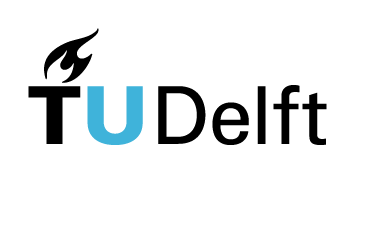

<h1 style="text-align:center">Assignment Part 2</h1>
<h1 style="text-align:center">2024/2025</h1>


<h2><p>Faculty of Electrical Engineering, Mathematics, and Computer Science<br>
Mathematical Methods For Physics: Finite-Element Analysis (AP3001-FE)</p></h2>

Author:
  - Artur Palha

Original concept idea for stationary case: 
  - Carolina Úrzua-Torres
  - Dani Balagué Guardia

## <span style="color:red">DEADLINE</span> 
To be submitted **before 23:59 of January 17th, 2024**, via Brightspace, both the report (pdf) and code (zip file of folder with all code necessary to run: it should include this file and the folder `ap3001_fe`).

The assignment is planned so you are able to complete all tasks before this date. 

## Typesetting
The report must be typeset in either $\LaTeX$ or Word and converted to a pdf file.

# Assignment

Following up on the questions in the exam questions, you are asked to fill in the missing code in order to make this notebook run.

All the code you need to change is marked with `# TODO` at the end of the line. For each `# TODO` you can add the necessary code by fixing that line. Most code is straighforward, except in the assembly functions where you will need to use numpy array multiplication to make it in just one line. If it is easier for you to make it a sequence of `for` loops, feel free to do so. Just keep in mind that the changes you need to make are very localized and relatively simple.

All the changes you need to make are in the folder:

`ap3001_fe/assignment_functions`

Specifically, the following files and functions:

- `ap3001_fe/assignment_functions/__basis.py`
    - `basis_canonical_triangle(xi, eta)`
    - `grad_basis_canonical_triangle(xi, eta)`

- `ap3001_fe/assignment_functions/__mapping.py`
    - `mapping_triangle(xi, eta, vertices)`
    - `jacobian_triangle(xi, eta, vertices)`

- `ap3001_fe/assignment_functions/__local_assembly.py`
    - `generate_element_mass_matrix(basis, element_idx, sigma)`
    - `generate_element_vector(basis, element_idx, f)`

- `ap3001_fe/assignment_functions/__time_evolution.py`
    - `evolve_in_time(u_0, f, M, N, delta_t, theta, basis, tol=1e-10, t_step_max = 1000)`

The functions in the first three files are tested below (see Testing section). Once the tests pass, your functions are correctly implemented. Change the functions following the sequence in the tests (and presented above).

For the time evolution, you can see if your implementation is correct by checking if the difference between the steady state solution and the time evolution solution is close to the tolerance. If not, something is incorrectly implemented in your time integration.

# Import required libraries

In [2]:
# Import required libraries

# In principle, this cell should automatically install any missing packages.
# If not, install the required packages by hand:
#   - numpy
#   - scipy
#   - matplotlib
#   - scikit-fem

import sys

# Numpy
try:
    import numpy
except:
    !{sys.executable} -m pip install numpy

# Matplotlib
try:
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
except:
    !{sys.executable} -m pip install matplotlib

# Scipy
try:
    from scipy.sparse import identity as sp_identity
    from scipy.sparse.linalg import spsolve as solve
except:
    !{sys.executable} -m pip install scipy

# SkFEM
try:
    import skfem
except:
    !{sys.executable} -m pip install scikit-fem

# Our custom made functions and auxiliary functions
import ap3001_fe

# Define physical variables

In [3]:
sigma = 1.0  # as in the PDE

# Create the mesh

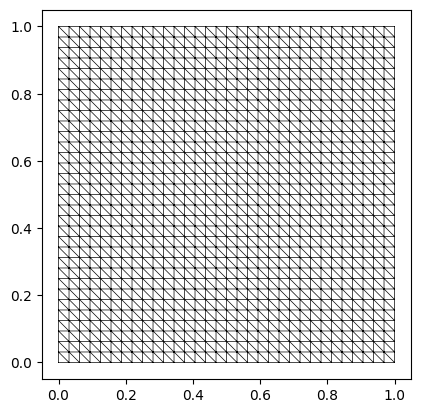

In [4]:
# Create the mesh
squareMesh = ap3001_fe.mesh.Mesh('square', refinement=5)

# And plot it
ax = squareMesh.draw()
plt.show()

# Define the essential boundary conditions

## $\Gamma_1$ essential boundary conditions (door)

In [5]:
# Essential boundary conditions at Gamma_1: door 

# First the function that defines if a point is on the Gamma_1 boundary or not
def on_boundary_g_1(x, y):
    return numpy.logical_and(x >= 0.8, y >= 1.0 - 10**(-8))

# Then the value of the boundary condition
def g_1(x, y):
       return 18.0 * numpy.ones(len(x))

## $\Gamma_3$ essential boundary conditions (window)

In [6]:
# Essential boundary conditions at Gamma_3: window 

# First the function that defines if a point is on the Gamma_3 boundary or not
def on_boundary_g_3(x, y):
       return numpy.logical_and(numpy.logical_and(x >= 0.2, x <= 0.4), y <= 10**(-8))

# Then the value of the boundary condition
def g_3(x, y):
       return -5.0 * numpy.ones(len(x))

## Generate the data structure that stores all essential boundary conditions

In [7]:
# Place them in the dictionary containing all essential boundary conditions
bcs = {'Gamma_1': {'on_boundary_function': on_boundary_g_1, 'g': g_1},\
       'Gamma_3': {'on_boundary_function': on_boundary_g_3, 'g': g_3}}

# Define the source term (heater)

## Source function for the heater on in the middle of the room

In [8]:
# Define the source function with the heater on
def f_heater(x, y):
    # First check which points are at the location of the source (heater)
    points_in_source_mask = numpy.logical_and(numpy.logical_and(x >= 0.4, x <= 0.6), numpy.logical_and(y >= 0.45, y <= 0.55))
    
    # Then assign the heat generation to the points at the location of the source (heater)
    f = numpy.zeros(len(x))
    f[points_in_source_mask] = 2500.0  # power generation of the heat source

    return f

## Source function for the heater off (no heater)

In [9]:
# Define the source function with the heater off (no heater)
def f_no_heater(x, y):
    return numpy.zeros(len(x))

# Generate the basis functions used to solve this problem

In [10]:
# Generate the hat basis functions
hat_basis = ap3001_fe.basis.HatBasisFunctions(squareMesh, bcs)

# Test implementations

Fill in the missing implementations on each of the functions tested below. Follow the sequence as they appear in the tests. Once all tests passit means you have correctly implemented the functions and your results will be correct.

## Test `__basis.py`

### Test `basis_canonical_triangle`

In [11]:
# Generate output
xi = numpy.array([0.0, 1.0, 0.0, 0.25, 0.25, 0.0])
eta = numpy.array([0.0, 0.0, 1.0, 0.0, 0.25, 0.25])
B_c_eval = ap3001_fe.assignment_functions.basis_canonical_triangle(xi, eta)

# Reference output
B_c_eval_reference = numpy.array([[1.  , 0.  , 0.  , 0.75, 0.5 , 0.75],
                                  [0.  , 1.  , 0.  , 0.25, 0.25, 0.  ],
                                  [0.  , 0.  , 1.  , 0.  , 0.25, 0.25]])

# Check correctness of results
error = B_c_eval_reference - B_c_eval

if numpy.abs(error).sum() > 1e-12:
    raise Exception("ap3001_fe.assignment_functions.basis_canonical_triangle is incorrectly implemented. Correct it in ap3001_fe/assignment_functions/__basis.py") 
else:
    print("|---------------------------------------|")
    print("| basis test output                     |")
    print("|---------------------------------------|")
    print("   ap3001_fe.assignment_functions.basis_canonical_triangle is correctly implemented.")

|---------------------------------------|
| basis test output                     |
|---------------------------------------|
   ap3001_fe.assignment_functions.basis_canonical_triangle is correctly implemented.


### Test `grad_basis_canonical_triangle`

In [12]:
# Generate output
xi = numpy.array([0.0, 1.0, 0.0, 0.25, 0.25, 0.0])
eta = numpy.array([0.0, 0.0, 1.0, 0.0, 0.25, 0.25])
grad_B_c_eval = ap3001_fe.assignment_functions.grad_basis_canonical_triangle(xi, eta)

# Reference output
grad_B_c_eval_reference = numpy.array([[[-1., -1.],
                                        [-1., -1.],
                                        [-1., -1.],
                                        [-1., -1.],
                                        [-1., -1.],
                                        [-1., -1.]],
                                       [[ 1.,  0.],
                                        [ 1.,  0.],
                                        [ 1.,  0.],
                                        [ 1.,  0.],
                                        [ 1.,  0.],
                                        [ 1.,  0.]],
                                       [[ 0.,  1.],
                                        [ 0.,  1.],
                                        [ 0.,  1.],
                                        [ 0.,  1.],
                                        [ 0.,  1.],
                                        [ 0.,  1.]]])

# Check correctness of results
error = grad_B_c_eval_reference - grad_B_c_eval

if numpy.abs(error).sum() > 1e-12:
    raise Exception("ap3001_fe.assignment_functions.grad_basis_canonical_triangle is incorrectly implemented. Correct it in ap3001_fe/assignment_functions/__basis.py") 
else:
    print("|---------------------------------------|")
    print("| grad basis test output                     |")
    print("|---------------------------------------|")
    print("   ap3001_fe.assignment_functions.grad_basis_canonical_triangle is correctly implemented.")

|---------------------------------------|
| grad basis test output                     |
|---------------------------------------|
   ap3001_fe.assignment_functions.grad_basis_canonical_triangle is correctly implemented.


## Test `__mapping.py`

### Test `mapping_triangle`

In [13]:
# Generate output
element_idx = 10  # choose one element (triangle)
element_vertices_idxs = squareMesh.elements[element_idx]  # get the indices of the vertices that make up the element (triangle)
vertices = squareMesh.vertices[element_vertices_idxs]  # extract the coordinates of the vertices

xi = numpy.array([0.0, 1.0, 0.0])  # compute the mapping for the three vertices of the canonical element (triangle)
eta = numpy.array([0.0, 0.0, 1.0])  # we should get the triangle we selected
x, y = ap3001_fe.assignment_functions.mapping_triangle(xi, eta, vertices)

# Reference output
x_reference = vertices[:, 0]
y_reference = vertices[:, 1]

# Check correctness of results
error_x = x_reference - x
error_y = y_reference - y

if (numpy.abs(error_x).sum() > 1e-12) or (numpy.abs(error_y).sum() > 1e-12):
    raise Exception("ap3001_fe.assignment_functions.mapping_triangle is incorrectly implemented. Correct it in ap3001_fe/assignment_functions/__mapping.py") 
else:
    print("|---------------------------------------|")
    print("| mapping triangle test output          |")
    print("|---------------------------------------|")
    print("   ap3001_fe.assignment_functions.mapping_triangle is correctly implemented.")

|---------------------------------------|
| mapping triangle test output          |
|---------------------------------------|
   ap3001_fe.assignment_functions.mapping_triangle is correctly implemented.


### Test `jacobian_triangle`

In [14]:
# Generate output
element_idx = 10  # choose one element (triangle)
element_vertices_idxs = squareMesh.elements[element_idx]  # get the indices of the vertices that make up the element (triangle)
vertices = squareMesh.vertices[element_vertices_idxs]  # extract the coordinates of the vertices

xi = numpy.array([0.0, 1.0, 0.0])  # compute the mapping for the three vertices of the canonical element (triangle)
eta = numpy.array([0.0, 0.0, 1.0])  # we should get the triangle we selected
J = ap3001_fe.assignment_functions.jacobian_triangle(xi, eta, vertices)

# Reference output
x, y = ap3001_fe.assignment_functions.mapping_triangle(xi, eta, vertices)
J_ref = numpy.zeros([2, 2])
J_ref[0, 0] = x[1] - x[0]
J_ref[0, 1] = x[2] - x[0]
J_ref[1, 0] = y[1] - y[0]
J_ref[1, 1] = y[2] - y[0]

# Check correctness of results
error_flag = False
if ~numpy.all(J[:, 0, 0] == J[0, 0, 0]):
    error_flag = True

if ~numpy.all(J[:, 0, 1] == J[0, 0, 1]):
    error_flag = True

if ~numpy.all(J[:, 1, 0] == J[0, 1, 0]):
    error_flag = True

if ~numpy.all(J[:, 1, 1] == J[0, 1, 1]):
    error_flag = True

if numpy.abs(J[0, :, :] - J_ref).sum() > 1e-12:
    error_flag = True

if error_flag:
    raise Exception("ap3001_fe.assignment_functions.jacobian_triangle is incorrectly implemented. Correct it in ap3001_fe/assignment_functions/__mapping.py") 
else:
    print("|---------------------------------------|")
    print("| jacobian triangle test output          |")
    print("|---------------------------------------|")
    print("   ap3001_fe.assignment_functions.jacobian_triangle is correctly implemented.")



|---------------------------------------|
| jacobian triangle test output          |
|---------------------------------------|
   ap3001_fe.assignment_functions.jacobian_triangle is correctly implemented.


## Test `__local_assembly.py`

### Test `generate_element_mass_matrix`

In [15]:
# Generate output
sigma = 1.0  # do not change this
element_idx = 10  # do not change this

M_local = ap3001_fe.assignment_functions.generate_element_mass_matrix(hat_basis, element_idx, sigma)

# Reference output
M_local_reference = numpy.array([[0.000162760416667, 0.               , 0.               ],
                                [0.               , 0.000162760416667, 0.               ],
                                [0.               , 0.               , 0.000162760416667]])

# Check correctness of results
if numpy.abs(M_local_reference - M_local).sum() > 1e-12:
    raise Exception("ap3001_fe.assignment_functions.generate_element_mass_matrix is incorrectly implemented. Correct it in ap3001_fe/assignment_functions/__local_assembly.py") 
else:
    print("|-------------------------------------------|")
    print("| generate element mass matrix test output  |")
    print("|-------------------------------------------|")
    print("   ap3001_fe.assignment_functions.generate_element_mass_matrix is correctly implemented.")

|-------------------------------------------|
| generate element mass matrix test output  |
|-------------------------------------------|
   ap3001_fe.assignment_functions.generate_element_mass_matrix is correctly implemented.


### Test `generate_element_vector`

In [16]:
# Generate output
element_idx = 20  # do not change this

f_local = ap3001_fe.assignment_functions.generate_element_vector(hat_basis, element_idx, f_heater)

# Reference output
f_local_reference = numpy.array([0.406901041666667, 0.406901041666667, 0.406901041666667])

# Check correctness of results
if numpy.abs(f_local_reference - f_local).sum() > 1e-12:
    raise Exception("ap3001_fe.assignment_functions.generate_element_vector is incorrectly implemented. Correct it in ap3001_fe/assignment_functions/__local_assembly.py") 
else:
    print("|-------------------------------------------|")
    print("| generate element vector test output       |")
    print("|-------------------------------------------|")
    print("   ap3001_fe.assignment_functions.generate_element_vector is correctly implemented.")

|-------------------------------------------|
| generate element vector test output       |
|-------------------------------------------|
   ap3001_fe.assignment_functions.generate_element_vector is correctly implemented.


# Generate all mass and stiffness matrices and source term vector

Note that the mass matrix $\boldsymbol{\mathsf{M}}$ and the stiffness matrix $\boldsymbol{\mathsf{N}}$ do not change in time, therefore we can compute them in advance and then use them in the time stepping procedure. This avoids computing these matrices at each time step, which is time consuming.

The same is true for the source terms, since in this case the source terms are not time dependent.

In [17]:
# Generate system matrices and right hand side source vector

# Generate the mass matrix
M = ap3001_fe.assembly.assemble_global_mass_matrix(hat_basis, 1.0)

# Generate the stiffness matrix
N = ap3001_fe.assembly.assemble_global_stiffness_matrix(hat_basis, sigma)

# Generate source vectors
# Note: the source vectors are not time dependent
f_h_heater =  ap3001_fe.assembly.assemble_global_vector(hat_basis, f_heater)
f_h_no_heater =  ap3001_fe.assembly.assemble_global_vector(hat_basis, f_no_heater)


# Compute temperature distributions

We are interested in computing the stationary (equilibrium) temperature distribution when the heater is turned on.

In order to do that we will proceed in two ways:

1. Compute the stationary solution with the heater on
2. Evolve the transient solution until we reach the stationary state (no temperature changes in time)

## Compute temperature distribution with heater on using stationary solution

To find the temperature distribution with the heater on using the stationary solution approach we just need to solve the heat equation in the steady state limit, i.e.,

$$
\frac{\partial T}{\partial t} = 0
$$

This means that the heat equation

$$
\frac{\partial T}{\partial t} - \nabla\cdot\nabla T = f
$$

becomes

$$
- \nabla\cdot\nabla T = f\,.
$$

C:\Users\david\AppData\Local\Temp\ipykernel_11500\1335383794.py:8: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u_end = solve(N_bc, f_h_heater_bc)


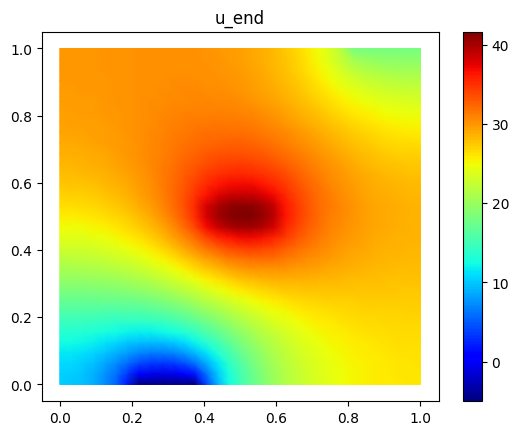

In [18]:
# Compute the same stationary solution with the heater on directly
# i.e., without evolving in time
# Impose the boundary conditions
N_bc = ap3001_fe.assembly.impose_boundary_conditions_matrix(N, hat_basis)
f_h_heater_bc = ap3001_fe.assembly.impose_boundary_conditions_vector(f_h_heater, hat_basis)

# Find the solution
u_end = solve(N_bc, f_h_heater_bc)

# Plot the solution
fig, ax = plt.subplots()
ap3001_fe.mesh.plot(squareMesh, u_end, shading='gouraud', colorbar=True, ax=ax)
plt.title("u_end")
plt.show()

## Compute temperature distribution with heater on using transient solution

To compute the temperature distribution with heater on using the transient solution we will proceed in the following way.

If you recall the lectures, in order to solve a time dependent solution, besides the boundary conditions, we also need an initial condition $T_{0}(x, y) := T(x, y; t=0)$.

How can we find a suitable initial condition? One way of finding an initial condition is to compute the steady state solution without any heater on. This is the temperature distribution in the room we would obtain if we turned off the heater for a long time and let the room reach a stationary temperature distribution.

This can be done following exactly the same procedure used to compute the stationary temperature distribution with the heater on (see above), but now with the source term set to zero (no heater).

Once we have the initial temperature distribution, we can evolve it in time (using the $\theta$-method, for example) until the temperature in all points stops changing in time (or changes very little).

This is exactly what we will do.

### Compute initial temperature distribution (initial condition) via the stationary solution with heater off

C:\Users\david\AppData\Local\Temp\ipykernel_11500\441641910.py:10: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u_0 = solve(N_bc, f_h_no_heater_bc)


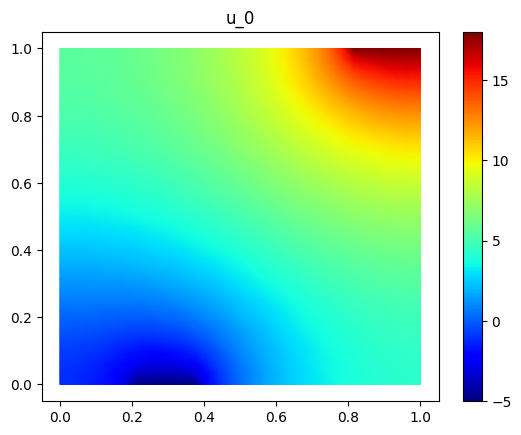

In [19]:
# Find the stationary solution of the temperature without any heat source.
# This will give us the temperature distribution in the room if we leave
# the heater off for a long time, i.e., until the temperature stabilizes.

# Impose the boundary conditions
N_bc = ap3001_fe.assembly.impose_boundary_conditions_matrix(N, hat_basis)
f_h_no_heater_bc = ap3001_fe.assembly.impose_boundary_conditions_vector(f_h_no_heater, hat_basis)

# Find the solution
u_0 = solve(N_bc, f_h_no_heater_bc)

# Plot the solution
fig, ax = plt.subplots()
ap3001_fe.mesh.plot(squareMesh, u_0, shading='gouraud', colorbar=True, ax=ax)
plt.title("u_0")
plt.show()

### Compute heat distribution with heater on by evolving the temperature in time

As mentioned above, we now evolve the initial temperature distribution (the one we obtained via the stationary condition without any heater) until there is no change in time.

c:\uni-files\FE\assignment-2\code\venv\Lib\site-packages\scipy\sparse\_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


End time step:  905
End time     :  9.05


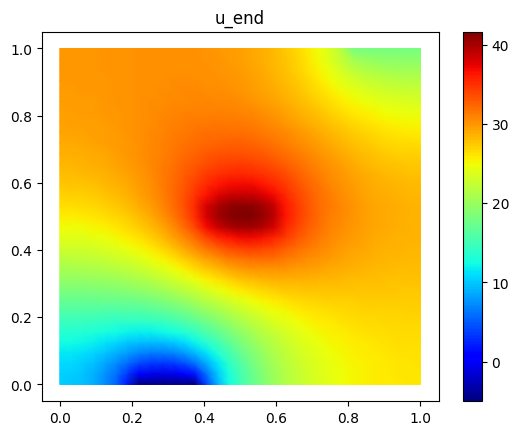

In [20]:
# Now we will turn on the heater and see how the temperature evolves
# until it reaches equilibrium

# Define the time stepping size and the time stepping theta-parameter
delta_t = 0.01
theta = 1.0  # 0   : Forward Euler
             # 1/2 : Crank-Nicholson
             # 1   : Backward Euler

# Evolve in time until equilibrium
t_step, u_t, u_diffs, t_steps = ap3001_fe.evolve_in_time(u_0, f_h_heater, M, N, delta_t, theta, hat_basis, tol=1e-10, t_step_max = 2000)

print("End time step: ", t_step)
print("End time     : ", t_step*delta_t)

# Plot the final solution (stationary temperature distribution)
fig, ax = plt.subplots()
ap3001_fe.mesh.plot(squareMesh, u_t[-1], shading='gouraud', colorbar=True, ax=ax)
plt.title("u_end")
plt.show()

## Compare the last step of the transient solution with the stationary solution

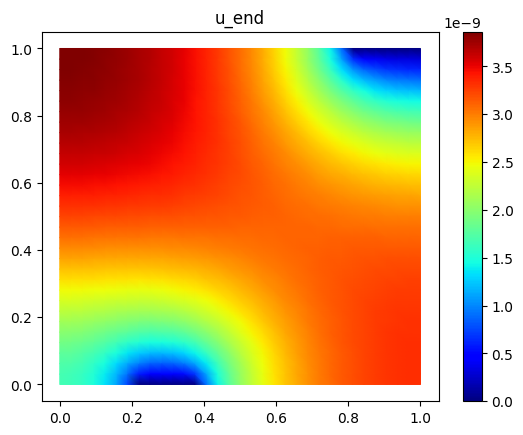

In [21]:
# Plot the difference between the two stationary solutions
fig, ax = plt.subplots()
ap3001_fe.mesh.plot(squareMesh, numpy.abs(u_end - u_t[-1]), shading='gouraud', colorbar=True, ax=ax)
plt.title("u_end")
plt.show()

The two solutions are essentially identical (as expected). The difference is very close to the tolerence we used as a stopping criterium in the time evolution. Recall that the time evolution would stop once the temperature between one time step and the next changed by less than the tolerance.